##**Computer Vision Final Project** <br>
Mehrshad Saadatinia

Version 2

In [1]:
import os
import cv2
import random
import numpy as np
from sklearn import datasets
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras import backend as K
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
from tensorflow.python.keras.utils.vis_utils import plot_model

This notebook is also similar to version 1 in terms of algorithms as method, However the data is Scikit-Learn's face pairs and in smaller dimensions

In [2]:
base = '/content'
os.chdir(os.path.join(base, 'drive', 'MyDrive'))

In [3]:
train_data = datasets.fetch_lfw_pairs(subset='train', color=True)
val_data = datasets.fetch_lfw_pairs(subset='10_folds', color=True)
test_data = datasets.fetch_lfw_pairs(subset='test', color=True)

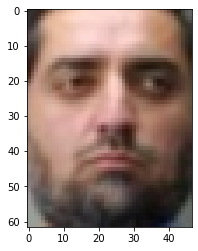

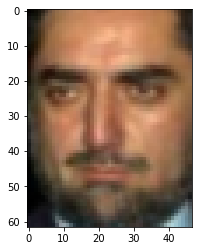

1


In [4]:
def show_pair(i):
  plt.imshow(train_data['pairs'][i][0].astype('int32'))
  plt.show()
  plt.imshow(train_data['pairs'][i][1].astype('int32'))
  plt.show()
  print(train_data['target'][i])


show_pair(4)

In [5]:
DIM = 60

def make_triplets(bunch, resize_to=(DIM, DIM)):
  triplets = []
  for pair, label in zip(bunch['pairs'], bunch['target']):
    triplets.append((cv2.resize(pair[0], resize_to), cv2.resize(pair[1], resize_to), label))
  return triplets



def infere_labels(triplets):
  X, y = [], []
  for left, right, label in triplets:
    X.append([left, right])
    y.append(label)
  return np.array(X).astype('float32') / 255.0, np.array(y).astype('float32')


In [6]:
random.seed(42)

train_triplets = make_triplets(train_data)
val_triplets = make_triplets(val_data)

random.shuffle(train_triplets)
random.shuffle(val_triplets)

X_train, y_train = infere_labels(train_triplets)
X_val, y_val = infere_labels(val_triplets)

In [7]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2200, 2, 60, 60, 3), (2200,), (6000, 2, 60, 60, 3), (6000,))

In [8]:
def init_base_model():
    input = keras.layers.Input(shape=(DIM, DIM, 3), name="base_input")
    x = keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu")(input)
    x = keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
    x = keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
    x = keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
    x = keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
    x = keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
    x = keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
    x = keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
    x = keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
    x = keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
    x = keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
    x = keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
    x = keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
    x = keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
    x = keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
    x = keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
    x = keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(4096,activation="relu")(x)
    x = keras.layers.Dense(4096,activation="relu")(x)
    return Model(inputs=input, outputs=x)

base_model = init_base_model()

In [9]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [10]:
input_l = keras.layers.Input(shape=(DIM, DIM, 3), name='left_input')
vect_output_l = base_model(input_l)

input_r = keras.layers.Input(shape=(DIM, DIM, 3), name='right_input')
vect_output_r = base_model(input_r)

output = keras.layers.Lambda(euclidean_distance, name='output_layer', 
                output_shape=eucl_dist_output_shape)([vect_output_l, vect_output_r])

model = Model([input_l, input_r], output)

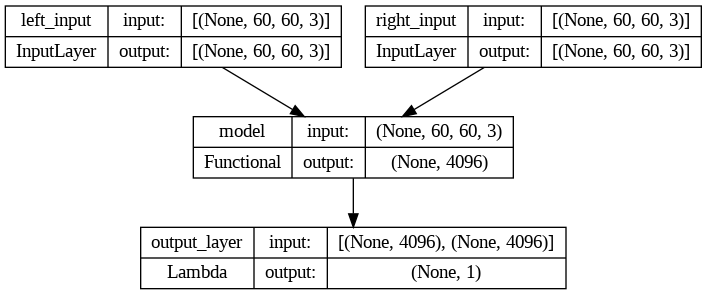

In [11]:
from keras.utils import plot_model
tf.keras.utils.plot_model(model, to_file='siamese_model.png', show_shapes=True)

In [12]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss


def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [13]:
count = 3000
X_train = np.concatenate([X_train, X_val[:count]])
y_train = np.concatenate([y_train, y_val[:count]])
X_val = X_val[count:]
y_val = y_val[count:]

In [58]:
rms = RMSprop(learning_rate=0.00005)
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([X_train[:, 0], X_train[:, 1]], y_train, epochs=80, validation_data=([X_val[:, 0], X_val[:, 1]], y_val))

Epoch 1/80
163/163 [==============================] - 22s 125ms/step - loss: 0.2762 - val_loss: 0.2276
Epoch 2/80
163/163 [==============================] - 18s 114ms/step - loss: 0.2382 - val_loss: 0.2124
Epoch 3/80
163/163 [==============================] - 19s 114ms/step - loss: 0.2154 - val_loss: 0.2018
Epoch 4/80
163/163 [==============================] - 18s 113ms/step - loss: 0.1982 - val_loss: 0.2305
Epoch 5/80
163/163 [==============================] - 18s 113ms/step - loss: 0.1896 - val_loss: 0.2037
Epoch 6/80
163/163 [==============================] - 18s 113ms/step - loss: 0.1796 - val_loss: 0.1901
Epoch 7/80
163/163 [==============================] - 19s 114ms/step - loss: 0.1708 - val_loss: 0.1848
Epoch 8/80
163/163 [==============================] - 18s 113ms/step - loss: 0.1647 - val_loss: 0.1798
Epoch 9/80
163/163 [==============================] - 18s 113ms/step - loss: 0.1549 - val_loss: 0.2030
Epoch 10/80
163/163 [==============================] - 18s 113ms/step - l

In [59]:
model.save('face_model.h5')

In [20]:
model = keras.models.load_model('face_model.h5', custom_objects={"contrastive_loss": contrastive_loss_with_margin(margin=1)})

In [21]:
loss = model.evaluate([X_val[:, 0], X_val[:, 1]], y_val)

y_pred_train = model.predict([X_train[:, 0], X_train[:, 1]])
train_accuracy = compute_accuracy(y_train, y_pred_train)

y_pred_val = model.predict([X_val[:, 0], X_val[:, 1]])
val_accuracy = compute_accuracy(y_val, y_pred_val)

print("Loss = {}, Train Accuracy = {}% Validation Accuracy = {}%".format(loss, round(train_accuracy * 100, 2),  round(val_accuracy * 100, 2)))

94/94 [==============================] - 2s 27ms/step
Loss = 0.15225492417812347, Train Accuracy = 99.92% Validation Accuracy = 78.47%


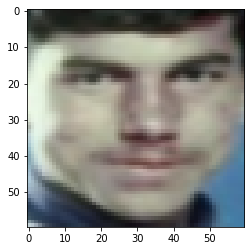

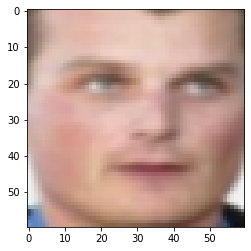

Not same
1/1 [==============================] - 0s 495ms/step
Prediction: 0.0
Distance: 1.217295527458191


In [22]:
def compare(i, X, y):
  plt.imshow(X[i][0])
  plt.show()
  plt.imshow(X[i][1])
  plt.show()
  print('Not same' if y[i] == 0.0 else 'Same')
  distance =  model.predict([X[i:i+1, 0], X[i:i+1, 1]])
  print(f'Prediction: {float(distance < 0.5)}')
  print(f'Distance: {np.squeeze(distance)}')

compare(25, X_val, y_val)

####**Test**

In [23]:
test_triplets = make_triplets(test_data)
random.seed(42)
random.shuffle(test_triplets)
X_test, y_test = infere_labels(test_triplets)

In [65]:
X_test.shape

(1000, 2, 60, 60, 3)

In [24]:
test_loss = model.evaluate([X_test[:, 0], X_test[:, 1]], y_test)

y_pred_test = model.predict([X_test[:, 0], X_test[:, 1]])
test_accuracy = compute_accuracy(y_test, y_pred_test)
print(f'Test Loss: {loss}, Test Accuracy: {test_accuracy}')

32/32 [==============================] - 1s 27ms/step
Test Loss: 0.15225492417812347, Test Accuracy: 0.768


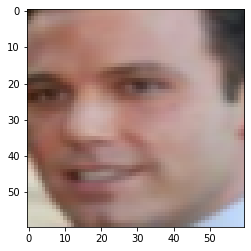

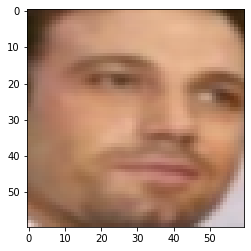

Same
1/1 [==============================] - 0s 28ms/step
Prediction: 1.0
Distance: 0.04967010021209717


In [26]:
compare(17, X_test, y_test)